In [1]:
#!/usr/bin/env python3
import numpy as np
import glob

data_directory = "./vis_project_data/"

# Default weights; used if not set
default_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

################################################################################


def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file.
    Assumes total session duration is 360s, otherwise returns 'nan'.
    This could be modified simply to also return other details of the session."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            # print(count, line)
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_catagory = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_catagory - 1] * duration
        return score / total_duration
        return score if np.abs(total_duration - 1.0) < 1.0e-5 else np.nan


################################################################################


def print_scores(
    ca, peer, cognitive_weights=default_weights, social_weights=default_weights
):
    """Calculates the scores for given ca/peer pair.
    It simply prints the result to screen - to be useful, you will want
    to actually store this data (e.g., return a struct or array etc.).
    """
    trained = "Trained" if "u" <= peer[0] <= "z" else "Untrained"
    print(ca, peer, f"({trained})")
    for ses_type, whatdoor, which in combined_scenarios:

        weights = cognitive_weights if ses_type == "cog" else social_weights

        # glob creates the list of filenames that match the given pattern
        # '*' is a wildcard
        files = glob.glob(
            data_directory + f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        )

        if len(files) == 0:
            continue

        scores = []
        for file in files:
            tmp_score = combined_score(file, weights)
            if not np.isnan(tmp_score):
                scores.append(tmp_score)
        scores = np.array(scores)

        mean = scores.mean()
        sdev = scores.std(ddof=1)  # "corrected" sdev
        sem = sdev / np.sqrt(len(scores))
        # Equiv. to:
        # sdev = scores.std()
        # sem = sdev / np.sqrt(len(scores) - 1)

        # len(scores) is the total number of kept (complete) sessions [for this ca/peer]
        # len(files) is the total number of sessions (files) in data directory
        print(
            f"{ses_type:3} {whatdoor:7} {which:5}: {mean:6.3f} +/- {sem:.3f}  [{len(scores)}/{len(files)}]"
        )


################################################################################
def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    list = []
    for file in all_files:
        t = file.split("-")
        list.append([t[4], t[5]])

    return np.unique(list, axis=0)


################################################################################

if __name__ == "__main__":

    # Example usage:

    ca_peer_list = unique_pairs()
    print(ca_peer_list)

    print()

    # From the thesis:
    soc_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match table 5.1 of thesis
    # cog_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

    # Match matlab example:
    cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])

    # # Example:
    # ca = "albert"
    # peer = "lydia"
    # print_scores("albert", "lydia", cog_weights, soc_weights)

    # Or, for all pairs:
    for ca, peer in ca_peer_list:
        print()
        print_scores(ca, peer, cog_weights, soc_weights)

################################################################################




[['albert' 'lydia']
 ['albert' 'ulrich']
 ['barry' 'mario']
 ['barry' 'viola']
 ['chris' 'nellie']
 ['chris' 'wendy']
 ['dana' 'oscar']
 ['dana' 'xavier']
 ['ellie' 'peter']
 ['ellie' 'yoshi']
 ['ellie' 'zara']]


albert lydia (Untrained)
cog indoor  base :  0.033 +/- 0.027  [4/4]
cog indoor  inter:  0.168 +/- 0.084  [13/13]
cog outdoor base :  0.245 +/- 0.110  [4/4]
cog outdoor inter:  0.347 +/- 0.101  [10/10]
so  indoor  base :  0.097 +/- 0.043  [4/4]
so  indoor  inter:  0.129 +/- 0.034  [13/13]
so  outdoor base :  0.101 +/- 0.089  [4/4]
so  outdoor inter:  0.055 +/- 0.016  [10/10]

albert ulrich (Trained)
cog indoor  base :  0.286 +/- 0.102  [5/5]
cog indoor  inter:  0.709 +/- 0.079  [10/10]
cog outdoor base :  0.382 +/- 0.200  [6/6]
cog outdoor inter:  0.822 +/- 0.099  [7/7]
so  indoor  base :  0.496 +/- 0.208  [5/5]
so  indoor  inter:  1.026 +/- 0.099  [10/10]
so  outdoor base :  0.132 +/- 0.060  [6/6]
so  outdoor inter:  1.069 +/- 0.181  [7/7]

barry mario (Untrained)
cog indoor 

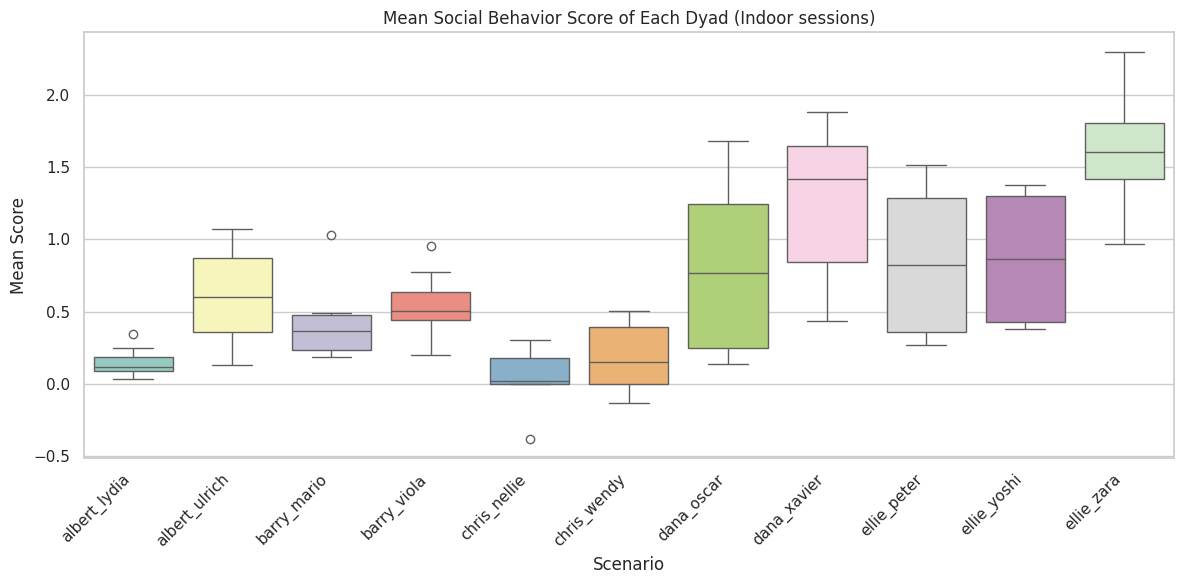

done


In [2]:
#!/usr/bin/env python3
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data_directory = "./vis_project_data/"

# Default weights; used if not set
default_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

# Types of sessions/files:
session_types = ["so" , "cog"]
whatdoors = ["indoor" , "outdoor"]
whichs = ["base", "inter"]

# Combine to single iterable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file.
    Assumes total session duration is 360s, otherwise returns 'nan'.
    This could be modified simply to also return other details of the session."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_catagory = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_catagory - 1] * duration
        return score / total_duration
        return score if np.abs(total_duration - 1.0) < 1.0e-5 else np.nan

def print_scores(
    ca, peer, cognitive_weights=default_weights, social_weights=default_weights
):
    """Calculates the scores for given ca/peer pair.
    It simply prints the result to screen - to be useful, you will want
    to actually store this data (e.g., return a struct or array etc.)."""
    scores_dict = {}
    trained = "Trained" if "u" <= peer[0] <= "z" else "Untrained"
    for ses_type, whatdoor, which in combined_scenarios:
        weights = cognitive_weights if ses_type == "cog" else social_weights
        files = glob.glob(
            data_directory + f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        )
        if len(files) == 0:
            continue

        scores = []
        for file in files:
            tmp_score = combined_score(file, weights)
            if not np.isnan(tmp_score):
                scores.append(tmp_score)
        scores = np.array(scores)
        mean = scores.mean()
        scores_dict[f"{ses_type}_{whatdoor}_{which}"] = mean

    return scores_dict

def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    list = []
    for file in all_files:
        t = file.split("-")
        list.append([t[4], t[5]])

    return np.unique(list, axis=0)

if __name__ == "__main__":
    ca_peer_list = unique_pairs()
    soc_weights = np.array([-1, 0, 1, 2, 2, 3, 5])
    cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])

    data = []
    for ca, peer in ca_peer_list:
        scores_dict = print_scores(ca, peer, cog_weights, soc_weights)
        scores_dict['ca_peer'] = f"{ca}_{peer}"
        data.append(scores_dict)

    df = pd.DataFrame(data)
    df.set_index('ca_peer', inplace=True)
    df = df.T.reset_index()
    df = df.rename(columns={'index': 'scenario'})

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, palette="Set3")
    plt.xticks(rotation=45, ha='right')
    plt.title("Mean Social Behavior Score of Each Dyad (Indoor sessions)")
    plt.ylabel("Mean Score")
    plt.xlabel("Scenario")
    plt.tight_layout()
    plt.show()
    print("done")


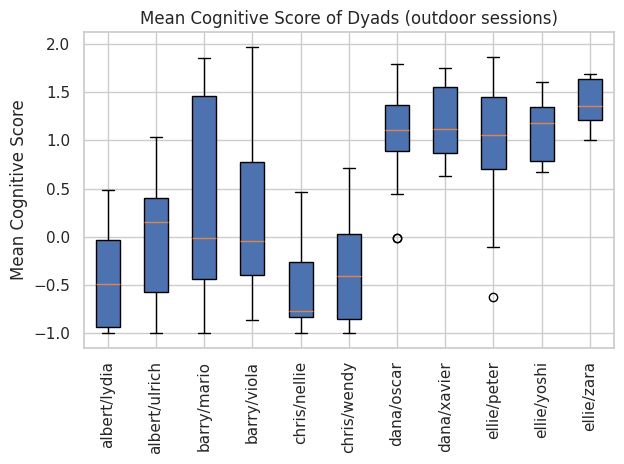

done


In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt

data_directory = "./vis_project_data/"

# Default weights; used if not set
default_weights = np.array([-1, 0, 1, 2, 2, 3, 5])

# Types of sessions/files:
session_types = ["cog"]
whatdoors = ["outdoor"]
whichs = ["base", "inter"]

# Combine to single iterable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_category = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_category - 1] * duration
        return score / total_duration

def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    pairs = []
    for file in all_files:
        t = file.split("-")
        pairs.append([t[4], t[5]])

    return np.unique(pairs, axis=0)

def get_scores(ca, peer, cognitive_weights=default_weights):
    """Calculates the scores for given ca/peer pair."""
    scores = []
    for ses_type, whatdoor, which in combined_scenarios:
        weights = cognitive_weights if ses_type == "cog" else default_weights
        files = glob.glob(
            data_directory + f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        )

        if len(files) == 0:
            continue

        for file in files:
            tmp_score = combined_score(file, weights)
            if not np.isnan(tmp_score):
                scores.append(tmp_score)
    return np.array(scores)

def plot_cognitive_scores(ca_peer_list, cognitive_weights=default_weights):
    """Plots the cognitive scores for all ca/peer pairs."""
    fig, ax = plt.subplots()
    data = []

    for ca, peer in ca_peer_list:
        scores = get_scores(ca, peer, cognitive_weights)
        if len(scores) > 0:
            data.append(scores)

    ax.boxplot(data, patch_artist=True)
    ax.set_xticklabels([f"{ca}/{peer}" for ca, peer in ca_peer_list])
    ax.set_ylabel('Mean Cognitive Score')
    ax.set_title('Mean Cognitive Score of Dyads (outdoor sessions)')

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    ca_peer_list = unique_pairs()
    plot_cognitive_scores(ca_peer_list)

print('done')
